In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver

In [3]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

In [4]:
from sympy import cos,sin,pi,symbols,diff,lambdify

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=u_symbolic**3-laplacian(u_symbolic)
f_symbolic

cos(4*pi*x)**3*cos(pi*y/2)**3 + 65*pi**2*cos(4*pi*x)*cos(pi*y/2)/4

In [5]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2

In [9]:
sigma=0.1
int_point_number=500
ext_point_number=200


u_1=PDESolver(
    X_int=np.concatenate([make_points_inside(int_point_number),make_points_inside(int_point_number,range_model=np.array([[-1,0.2],[-1,1]]))]),
    X_boundary=make_points_boundary(ext_point_number),
    sigma=sigma,
    name='1')
u_2=PDESolver(
    X_int=np.concatenate([make_points_inside(int_point_number),make_points_inside(int_point_number,range_model=np.array([[0.2,1],[-1,1]]))]),
    X_boundary=make_points_boundary(ext_point_number),
    sigma=sigma,
    name='2')
u_1.fit(f,real_u,tau,dtau,nugget=1e-5)
u_2.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 8.240e-08: : 5it [00:01,  2.97it/s]
Current residual 1.397e-07: : 5it [00:01,  3.78it/s]


In [10]:
def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

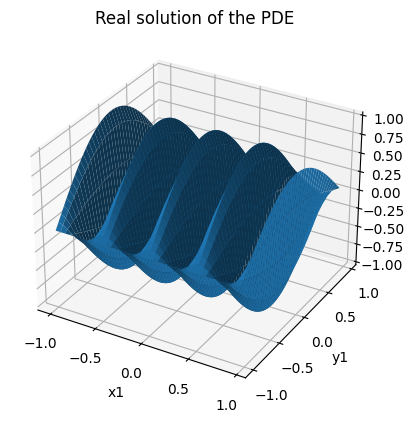

In [11]:
fig=plot_function(real_u)
plt.title('Real solution of the PDE')
plt.show()

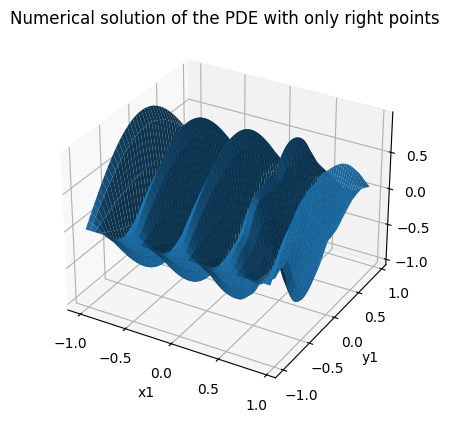

In [12]:
fig=plot_vectorized_function(u_1)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

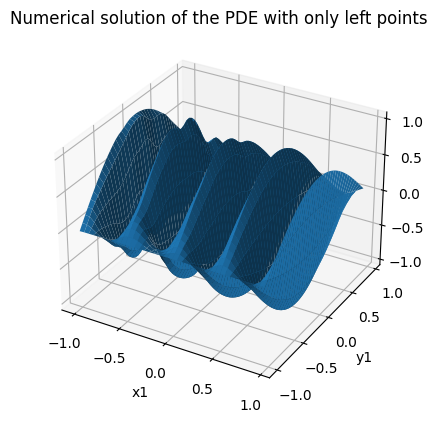

In [13]:
fig=plot_vectorized_function(u_2)
plt.title('Numerical solution of the PDE with only left points')
plt.show()

In [14]:
aggregate=Aggregate([u_1,u_2],sigma=sigma,nugget=1e-5)

M [[ 4.57774414e-04 -2.51933120e-03]
 [-4.60792889e-06  7.85505668e-06]
 [ 1.14439256e-04 -5.65409006e-05]
 ...
 [-1.01962621e-02 -2.38966018e-02]
 [ 3.22111235e-02  2.50747621e-02]
 [ 6.59844406e-02  6.49112266e-02]]
COV mat [[[0.99973867 0.99970132]
  [0.99970132 0.9999638 ]]

 [[1.00000745 0.99998913]
  [0.99998913 1.0000016 ]]

 [[0.99998692 0.99997333]
  [0.99997333 1.00000546]]

 ...

 [[0.99998058 0.99996692]
  [0.99996692 1.00000669]]

 [[0.99982    0.9998072 ]
  [0.9998072  1.00000823]]

 [[0.99953606 0.99951361]
  [0.99951361 0.99998897]]]
COV Y [[0.99972867 0.9999538 ]
 [0.99999745 0.9999916 ]
 [0.99997692 0.99999546]
 ...
 [0.99997058 0.99999669]
 [0.99981    0.99999823]
 [0.99952606 0.99997897]]
alpha [[0.12458168 0.87544102]
 [0.59507098 0.40492644]
 [0.29723413 0.70276542]
 ...
 [0.25568398 0.74431619]
 [0.05984868 0.94015335]
 [0.04510338 0.95490806]]


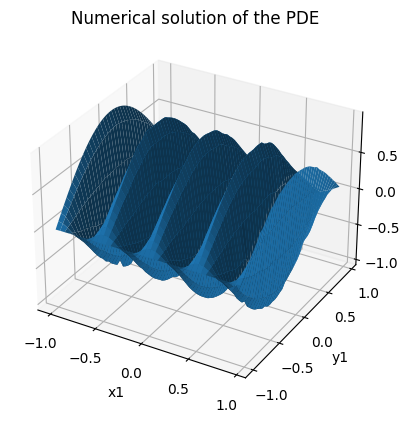

In [15]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [17]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_1=u_1(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_2=u_2(np.stack([X.flatten(),Y.flatten()],axis=-1))

cov_1=u_1.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_2=u_2.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_inter=u_2.covariate_with_other(u_1,np.stack([X.flatten(),Y.flatten()],axis=-1),sigma=0.1)
alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))

M [[ 0.00045777 -0.00251933]
 [ 0.0002811  -0.00154616]
 [ 0.00013883 -0.00084112]
 ...
 [ 0.01344131  0.01847397]
 [ 0.01399541  0.0190252 ]
 [ 0.01449204  0.01906512]]
COV mat [[[0.99973867 0.99970132]
  [0.99970132 0.9999638 ]]

 [[0.99987773 0.99982831]
  [0.99982831 0.99996238]]

 [[0.99995244 0.99990331]
  [0.99990331 0.9999675 ]]

 ...

 [[0.99980095 0.99970645]
  [0.99970645 0.99990955]]

 [[0.9998485  0.99962903]
  [0.99962903 0.99977666]]

 [[0.99987659 0.99945477]
  [0.99945477 0.99956199]]]
COV Y [[0.99972867 0.9999538 ]
 [0.99986773 0.99995238]
 [0.99994244 0.9999575 ]
 ...
 [0.99979095 0.99989955]
 [0.9998385  0.99976666]
 [0.99986659 0.99955199]]
alpha [[0.12458168 0.87544102]
 [0.26936289 0.73066323]
 [0.43356711 0.56645072]
 ...
 [0.31756936 0.68248514]
 [0.5978912  0.40218708]
 [0.79734466 0.20273087]]
COV mat [[[0.99973867 0.99970132]
  [0.99970132 0.9999638 ]]

 [[0.99987773 0.99982831]
  [0.99982831 0.99996238]]

 [[0.99995244 0.99990331]
  [0.99990331 0.9999675 ]]

In [18]:
np.linalg.norm(U_real-U_agg,ord=np.inf)

0.18905687119923065

In [19]:
np.linalg.norm(U_real-U_1,ord=np.inf)

0.5701475721588869

In [20]:
np.linalg.norm(U_real-U_2,ord=np.inf)

0.6173793342557459

In [21]:
x_sample=np.array([[-0.7,-0.6]])
print(real_u(x_sample[0]))
aggregate(x_sample)

-0.47552825814757677
M [[-0.47785375 -0.42392675]]
COV mat [[[1.00000898 0.9999701 ]
  [0.9999701  0.99998104]]]
COV Y [[0.99999898 0.99997104]]
alpha [[0.78046826 0.21953027]]


array([-0.46601444])

In [22]:
aggregate.alpha(x_sample)

COV mat [[[1.00000898 0.9999701 ]
  [0.9999701  0.99998104]]]
COV Y [[0.99999898 0.99997104]]


array([[0.78046826, 0.21953027]])

# Is $\sum_i \alpha_i=1$ ? 

In [23]:
np.max(np.abs(np.sum(alpha,axis=-1)-1))

0.00012991577935617116

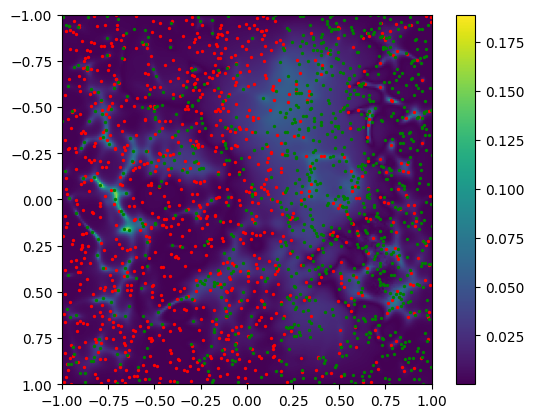

In [24]:
ax=plt.subplot()
im = ax.imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='r',s=2)
ax.scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='g',s=2)
plt.colorbar(im)

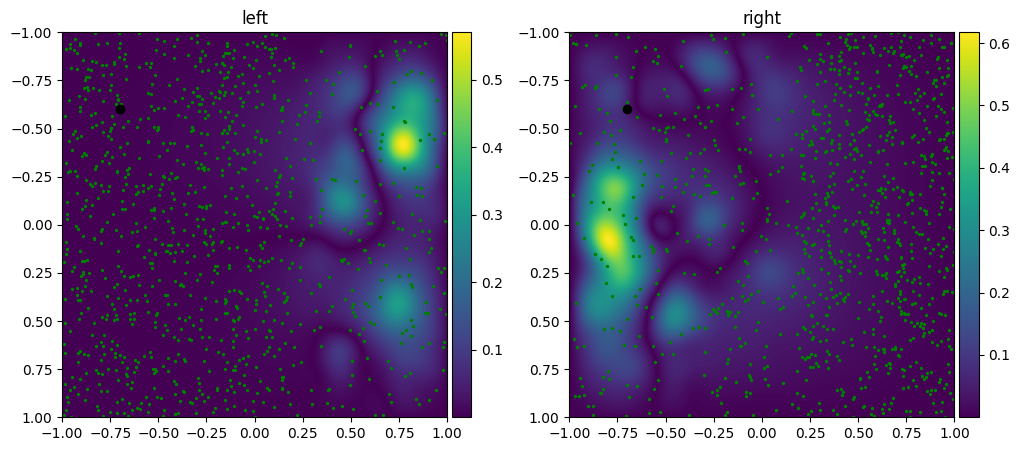

In [25]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.abs(U_1-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U_2-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

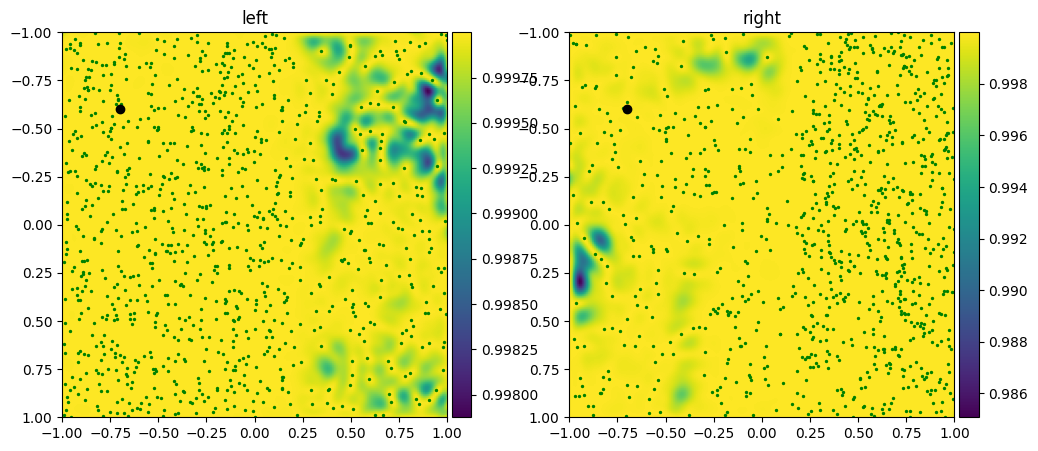

In [26]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(cov_1.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(cov_2.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

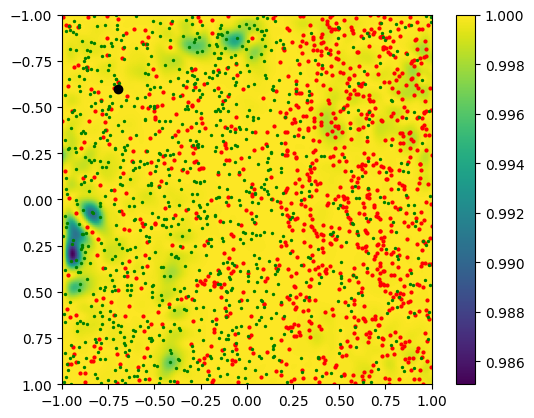

In [27]:
ax=plt.subplot()
im = ax.imshow(cov_inter.reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='r',s=4)
ax.scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
ax.scatter(x_sample[:,0],x_sample[:,1],c='k')
plt.colorbar(im)

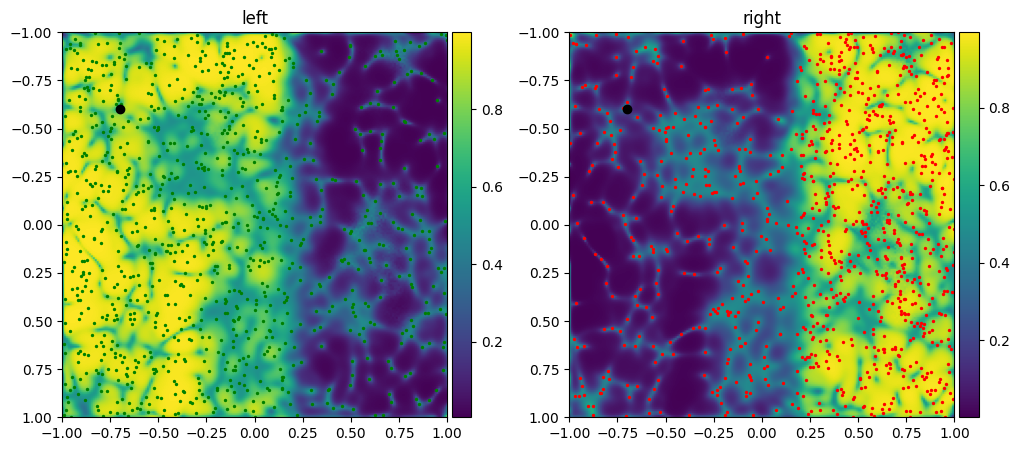

In [28]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha[:,0].reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(alpha[:,1].reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='r',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# Stop below

In [85]:
print(1/0)

ZeroDivisionError: division by zero

# Aggregating many models

In [35]:
def aggregate_many_models(N_models,N_points_inside,sigma,nugget_aggregate,nugget_model=1e-5):
    models=[]
    for k in range(N_models**2):
        x=-1+2*(k%N_models)/N_models
        y=-1+2*(k//N_models)/N_models
        X_int=np.concatenate([
            make_points_inside(Nd=N_points_inside,range_model=np.array([[x,x+2/N_models],[y,y+2/N_models]])),
            make_points_inside(Nd=N_points_inside),
        ])
        models.append(PDESolver(X_int=X_int,
                  X_boundary=make_points_boundary(N_points_inside//10),
                  sigma=sigma,
                  name=f'model_{k}'))
        models[-1].fit(f,real_u,tau,dtau,nugget=nugget_model)
    return Aggregate(models,sigma=sigma,nugget=nugget_aggregate)


In [48]:
big_aggregate=aggregate_many_models(N_models=3,N_points_inside=400,sigma=0.2,nugget_aggregate=1e-5,nugget_model=1e-5)
constant_mean=lambda x:np.array(list(map(lambda model:model(x),big_aggregate.models))).T.mean(axis=-1)

[[-1.0, -0.33333333333333337], [-1.0, -0.33333333333333337]]


Current residual 4.393e-08: : 5it [00:01,  4.97it/s]


[[-0.33333333333333337, 0.33333333333333326], [-1.0, -0.33333333333333337]]


Current residual 5.987e-07: : 5it [00:01,  4.96it/s]


[[0.33333333333333326, 0.9999999999999999], [-1.0, -0.33333333333333337]]


Current residual 5.159e-07: : 7it [00:01,  6.80it/s]


[[-1.0, -0.33333333333333337], [-0.33333333333333337, 0.33333333333333326]]


Current residual 7.613e-07: : 5it [00:00,  7.00it/s]


[[-0.33333333333333337, 0.33333333333333326], [-0.33333333333333337, 0.33333333333333326]]


Current residual 2.126e-07: : 5it [00:00,  6.62it/s]


[[0.33333333333333326, 0.9999999999999999], [-0.33333333333333337, 0.33333333333333326]]


Current residual 4.456e-07: : 5it [00:00,  6.80it/s]


[[-1.0, -0.33333333333333337], [0.33333333333333326, 0.9999999999999999]]


Current residual 3.992e-07: : 5it [00:00,  5.07it/s]


[[-0.33333333333333337, 0.33333333333333326], [0.33333333333333326, 0.9999999999999999]]


Current residual 3.349e-09: : 5it [00:00,  5.35it/s]


[[0.33333333333333326, 0.9999999999999999], [0.33333333333333326, 0.9999999999999999]]


Current residual 3.598e-08: : 5it [00:00,  5.95it/s]


M [[ 0.00084508 -0.00083262 -0.02861587 ... -0.00069862  0.00163885
   0.00029501]
 [ 0.0016199   0.00061658 -0.01011307 ...  0.00275646 -0.0018366
   0.00394266]
 [-0.00043623 -0.00102124 -0.00245805 ...  0.00477427 -0.01534921
  -0.00468632]
 ...
 [-0.02602203 -0.04495226 -0.08374399 ... -0.02841894  0.04816061
  -0.01537258]
 [ 0.01715079  0.02859167 -0.01075046 ...  0.01297399  0.10514031
   0.02893165]
 [ 0.04437391  0.09017198  0.04593048 ...  0.03630034  0.13871362
   0.06327944]]
COV mat [[[1.00000717 0.99998108 0.99980708 ... 0.99998911 0.99997143 0.99998799]
  [0.99998108 0.9999937  0.99979835 ... 0.99997665 0.99996135 0.99997586]
  [0.99980708 0.99979835 0.99981954 ... 0.99980294 0.99979325 0.99980467]
  ...
  [0.99998911 0.99997665 0.99980294 ... 1.00000204 0.99996796 0.99998324]
  [0.99997143 0.99996135 0.99979325 ... 0.99996796 0.99998401 0.99996688]
  [0.99998799 0.99997586 0.99980467 ... 0.99998324 0.99996688 1.00000086]]

 [[1.00000842 0.9999925  0.99968682 ... 0.99997

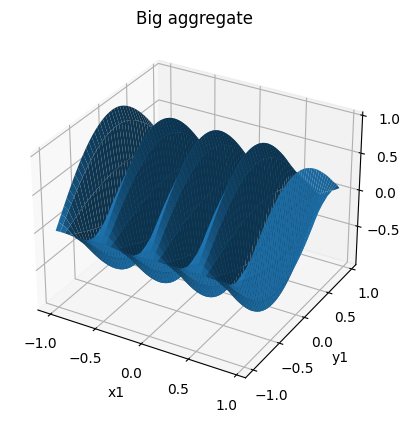

In [50]:
fig=plot_vectorized_function(big_aggregate)
plt.title('Big aggregate')
plt.show()

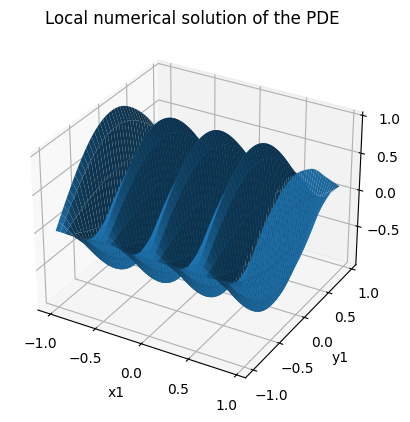

In [51]:
fig=plot_vectorized_function(big_aggregate.models[1])
plt.title('Local numerical solution of the PDE ')
plt.show()

In [52]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U_agg= big_aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_mean=constant_mean(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha=big_aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)

M [[ 8.45076563e-04 -8.32621344e-04 -2.86158721e-02 ... -6.98616533e-04
   1.63885403e-03  2.95007606e-04]
 [ 1.24042546e-03 -2.76962232e-04 -2.37916442e-02 ... -1.84254197e-05
   1.97082296e-03  2.17637022e-03]
 [ 1.51895516e-03  1.49362032e-04 -1.95621455e-02 ...  6.90408980e-04
   1.77038915e-03  3.47131692e-03]
 ...
 [-8.43258564e-03  6.76169239e-02  1.70478460e-02 ... -1.24680672e-02
   1.19684567e-01  1.20099181e-02]
 [-1.30542398e-02  7.20111306e-02  1.91051806e-02 ... -1.84951639e-02
   1.14633426e-01  1.11211110e-02]
 [-1.84039150e-02  7.54615717e-02  2.00756955e-02 ... -2.54303359e-02
   1.08097115e-01  9.91923526e-03]]
COV mat [[[1.00000717 0.99998108 0.99980708 ... 0.99998911 0.99997143 0.99998799]
  [0.99998108 0.9999937  0.99979835 ... 0.99997665 0.99996135 0.99997586]
  [0.99980708 0.99979835 0.99981954 ... 0.99980294 0.99979325 0.99980467]
  ...
  [0.99998911 0.99997665 0.99980294 ... 1.00000204 0.99996796 0.99998324]
  [0.99997143 0.99996135 0.99979325 ... 0.99996796 0

In [53]:
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)
error_mean=np.abs(U_real-U_mean)
error_each=[np.abs(U_real-model(np.stack([X.flatten(),Y.flatten()],axis=-1))) for model in big_aggregate.models]

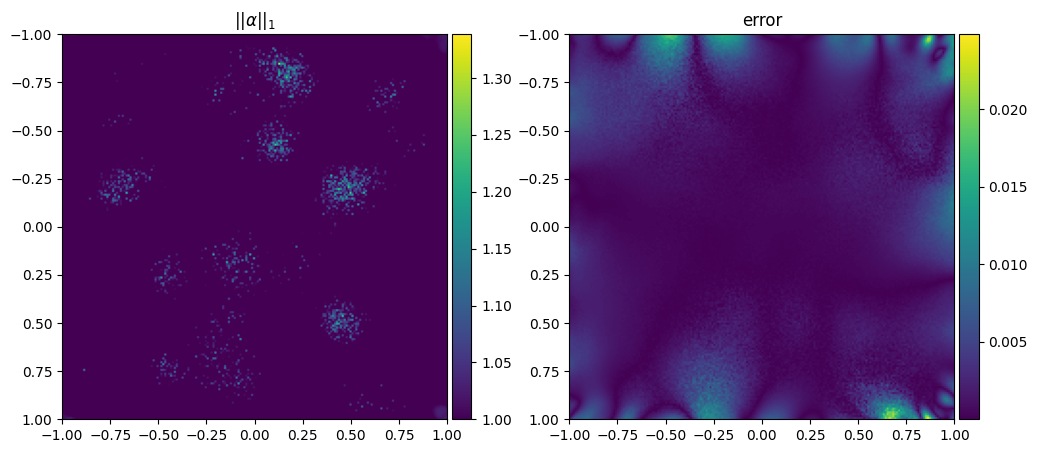

In [54]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha_norm.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].title.set_text('$|| \\alpha ||_1$')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(error_big_agg.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].title.set_text('error')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

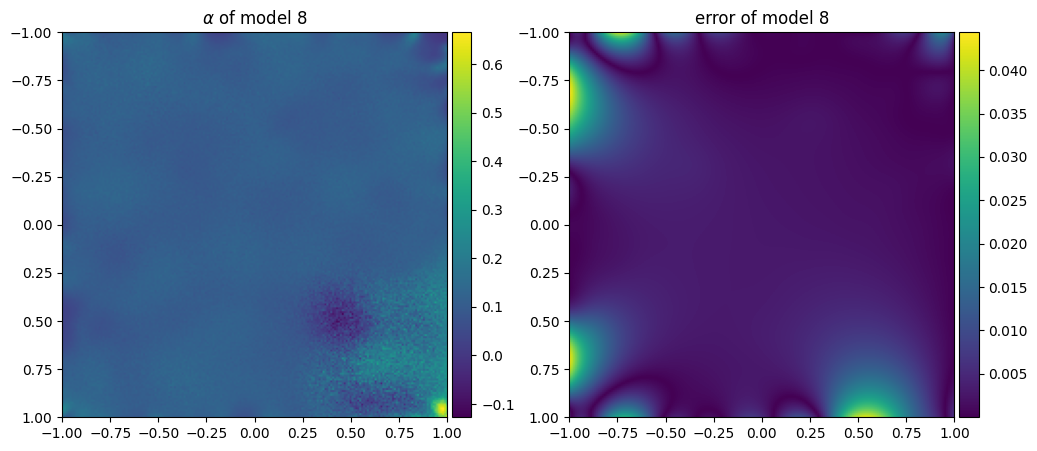

In [59]:
which=8

fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha[:,which].reshape(X.shape),extent=[-1,1,1,-1])
axes[0].title.set_text(f'$\\alpha $ of model {which}')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(error_each[which].reshape(X.shape),extent=[-1,1,1,-1])
axes[1].title.set_text(f'error of model {which}')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# Comparison of errors

In [56]:
print(f'mean aggregation : {error_mean.max():.2e}')
print(f'alpha aggregation : {error_big_agg.max():.2e}')

mean aggregation : 3.33e-02
alpha aggregation : 2.48e-02


In [57]:
np.max(np.abs(np.sum(alpha,axis=-1)-1))

2.031109245637097e-05

In [58]:
alpha[0]

array([ 0.31662246,  0.12037141,  0.01495671,  0.0557995 , -0.00859007,
        0.03176026,  0.20675784,  0.06869602,  0.19363624])